# Image Colorization Using CNN

In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import cifar10
from skimage.color import rgb2gray

## Loading Data
The CIFAR-10 dataset consists of 60000 32x32 colour images. There are 50000 training images and 10000 test images.


In [2]:
(y_train, _), (y_test, _) = cifar10.load_data()

Y_train = y_train[:50000]
Y_test = y_test[:10000]
Y_train = y_train.astype("float32")/255
Y_test = y_test.astype("float32")/255

print(f' Y Training Shape {y_train.shape}')
print(f' Y Test Shape {y_test.shape}')

170500096/170498071 [==============================] - 4s 0us/step
 Y Training Shape (50000, 32, 32, 3)
 Y Test Shape (10000, 32, 32, 3)


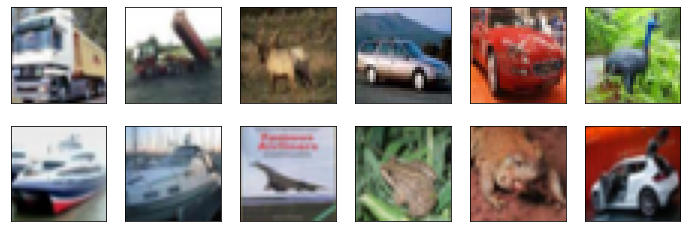

In [8]:
def plot_image(Nrow, Ncol, image_size, channel, *image_list):
    plt.figure(figsize=(2*Ncol, 2*Nrow))
    for i in range(1,Ncol+1):
        for j in range(len(image_list)):
            ax = plt.subplot(len(image_list), Ncol, i+j*Ncol)
            plt.imshow(image_list[j][i])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()
plot_image(2, 6, 32, 3, Y_train, Y_test)

## Converting Image from RGB to lab
The Lab [aka CIELAB / L*a*b*] completely separates the lightness from color. Lightness can be Thought of as some grayscale image. It only has luminosity but no colors. Channel L is responsible for that lightness (grayscale), and the other two channels ab are responsible for the colors. 

L channel – luminosity
a channel – green to magenta, negative is green, positive is magenta
b channel – blue to yellow, negative is blue, positive is yellow.

* Positive a & b values are warm tones (magenta and yellow), negative a&b values are cool tones (green and blue)
* Neutral (gray) tones from pure black to pure white – both a & b channels are zero.
* Faces – a & b (magenta and yellow) are both positive with b more positive than a (more yellow) except for small children & light skinned Caucasians where a = b.
* Natural greenery – a is negative (green) and b is positive (yellow) with b further from zero than is a (more yellow than green)
* Skys – b is negative (blue) and a is near zero but slightly negative (green)



In [9]:
from IPython.display import display, Image
from matplotlib.pyplot import imshow
from keras.layers import Conv2D, UpSampling2D, InputLayer
from keras.models import Sequential
from keras.preprocessing.image import img_to_array, load_img
from skimage.color import lab2rgb, rgb2lab

In [10]:
lab_image_train = rgb2lab(Y_train)
lab_image_test = rgb2lab(Y_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


([], <a list of 0 Text major ticklabel objects>)

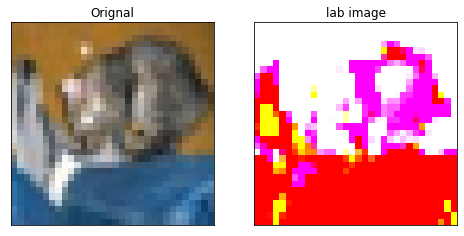

In [11]:
plt.figure(figsize=(8,8))
# Orignal Image
plt.subplot(1,2,1)
plt.imshow(Y_test[0])
plt.title('Orignal')
plt.xticks([])
plt.yticks([])

# ab channel Image
plt.subplot(1,2,2)
plt.imshow(lab_image_test[0])
plt.title('lab image')
plt.xticks([])
plt.yticks([])


## Normalize the Dataset

In [12]:
lab_train_norm = (lab_image_train + [0, 128, 128]) / [100, 255, 255]
lab_test_norm = (lab_image_test + [0, 128, 128]) / [100, 255, 255]

In [13]:
# The input will be the black and white layer
X_train = lab_train_norm[:,:,:,0]
X_test = lab_test_norm[:,:,:,0]

# The outpts will be the ab channels
y_train = lab_train_norm[:,:,:,1:]
y_test = lab_test_norm[:,:,:,1:]

print(f'Input shape: {X_train.shape}')
print(f'Output shape: {y_test.shape}')

Input shape: (50000, 32, 32)
Output shape: (10000, 32, 32, 2)


In [14]:
# Reshape Train Dataset
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], y_train.shape[2], 2)

# Reshape Test Dataset
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], y_test.shape[2], 2)

In [22]:
print(f'X_train shape {X_train.shape}')
print(f'y_train shape {y_train.shape}')
print(f'X_test shape {X_test.shape}')
print(f'y_test shape {y_test.shape}')

X_train shape (50000, 32, 32, 1)
y_train shape (50000, 32, 32, 2)
X_test shape (10000, 32, 32, 1)
y_test shape (10000, 32, 32, 2)


## Model Structure

In [16]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3,3), activation='tanh', padding='same'))

## Using Adam Optimizer

In [17]:
from keras.optimizers import Adam

# Finish model
LEARNING_RATE = 0.001
model.compile(optimizer=Adam(lr=LEARNING_RATE), loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 8)         80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          2320      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 32)          9248      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 32)         

In [18]:
%%time
# Fit the model
model.fit(x=X_train, y=y_train, batch_size=100, epochs=1000, verbose=0)

CPU times: user 30min 44s, sys: 4min 37s, total: 35min 21s
Wall time: 31min


### Evaluate

In [21]:
result = model.evaluate(X_test, y_test, batch_size=1)

10000/10000 [==============================] - 16s 2ms/step - loss: 0.0026


## Save Model

In [30]:
model.save("CNN_model_adam.h5")

In [31]:
# load the saved model
from keras.models import load_model
model = load_model('CNN_model_adam.h5')

In [32]:
# Predict
output = model.predict(X_test)

In [33]:
output.shape

(10000, 32, 32, 2)

In [34]:
# Combining the l and ab channel and convert to RGB format
cur = np.zeros((32, 32, 3))
cur[:,:,0] = X_test[1][:,:,0]
cur[:,:,1:] = output[1]

cur = (cur * [100, 255, 255]) - [0, 128, 128]
rgb_image = lab2rgb(cur)

([], <a list of 0 Text major ticklabel objects>)

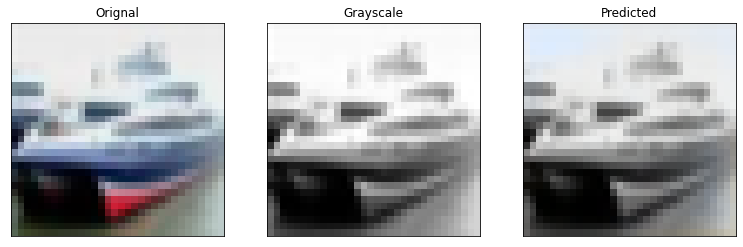

In [29]:
plt.figure(figsize=(13,13))
# Orignal Image
plt.subplot(1,3,1)
plt.imshow(Y_test[1])
plt.title('Orignal')
plt.xticks([])
plt.yticks([])

# Grayscale Image
plt.subplot(1,3,2)
plt.imshow(rgb2gray(Y_test[1]))
plt.title('Grayscale')
plt.xticks([])
plt.yticks([])

# Predicted Image
plt.subplot(1,3,3)
imshow(rgb_image)
plt.title('Predicted')
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text major ticklabel objects>)

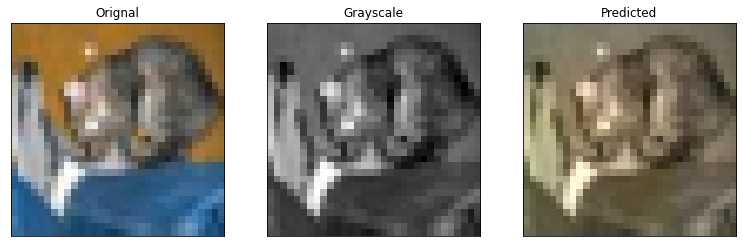

In [35]:
plt.figure(figsize=(13,13))
# Orignal Image
plt.subplot(1,3,1)
plt.imshow(Y_test[0])
plt.title('Orignal')
plt.xticks([])
plt.yticks([])

# Grayscale Image
plt.subplot(1,3,2)
plt.imshow(rgb2gray(Y_test[0]))
plt.title('Grayscale')
plt.xticks([])
plt.yticks([])

# Combining the l and ab channel and convert to RGB format
cur = np.zeros((32, 32, 3))
cur[:,:,0] = X_test[0][:,:,0]
cur[:,:,1:] = output[0]

cur = (cur * [100, 255, 255]) - [0, 128, 128]
rgb_image2 = lab2rgb(cur)

# Predicted Image
plt.subplot(1,3,3)
imshow(rgb_image2)
plt.title('Predicted')
plt.xticks([])
plt.yticks([])

# Using RMSPROP Optimizer

In [37]:
import tensorflow.keras.backend as K
K.clear_session()

In [38]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3,3), activation='tanh', padding='same'))

# Finish model
model.compile(optimizer='rmsprop', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 8)         80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          2320      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 32)          4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 32)          9248      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 32)          9

In [39]:
%%time
# Fit the model
model.fit(x=X_train, y=y_train, batch_size=100, epochs=1000, verbose=0)

CPU times: user 38min 31s, sys: 2min 3s, total: 40min 34s
Wall time: 34min 2s


In [40]:
model.evaluate(X_test, y_test, batch_size=1)

10000/10000 [==============================] - 15s 1ms/step - loss: 0.0025


0.002538382075726986

In [41]:
model.save("CNN_model_rmsprop.h5")

In [42]:
from keras.models import load_model
model = load_model('CNN_model_rmsprop.h5')

In [43]:
# Predict
output = model.predict(X_test)

In [44]:
# Combining the l and ab channel and convert to RGB format
cur = np.zeros((32, 32, 3))
cur[:,:,0] = X_test[0][:,:,0]
cur[:,:,1:] = output[0]

cur = (cur * [100, 255, 255]) - [0, 128, 128]
image3 = lab2rgb(cur)

In [45]:
cur = np.zeros((32, 32, 3))
cur[:,:,0] = X_test[1][:,:,0]
cur[:,:,1:] = output[1]

cur = (cur * [100, 255, 255]) - [0, 128, 128]
image4 = lab2rgb(cur)

([], <a list of 0 Text major ticklabel objects>)

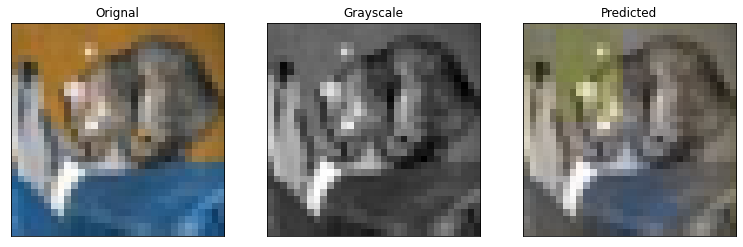

In [46]:
plt.figure(figsize=(13,13))
# Orignal Image
plt.subplot(1,3,1)
plt.imshow(Y_test[0])
plt.title('Orignal')
plt.xticks([])
plt.yticks([])

# Grayscale Image
plt.subplot(1,3,2)
plt.imshow(rgb2gray(Y_test[0]))
plt.title('Grayscale')
plt.xticks([])
plt.yticks([])

# Predicted Image
plt.subplot(1,3,3)
imshow(image3)
plt.title('Predicted')
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text major ticklabel objects>)

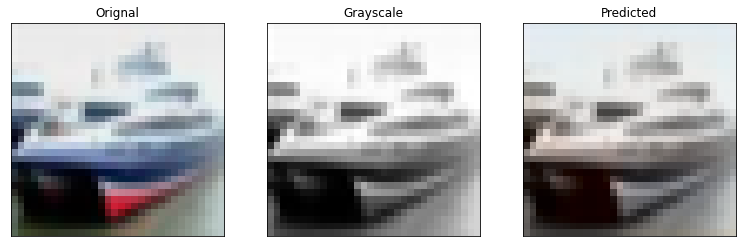

In [48]:
plt.figure(figsize=(13,13))
# Orignal Image
plt.subplot(1,3,1)
plt.imshow(Y_test[1])
plt.title('Orignal')
plt.xticks([])
plt.yticks([])

# Grayscale Image
plt.subplot(1,3,2)
plt.imshow(rgb2gray(Y_test[1]))
plt.title('Grayscale')
plt.xticks([])
plt.yticks([])

# Predicted Image
plt.subplot(1,3,3)
imshow(image4)
plt.title('Predicted')
plt.xticks([])
plt.yticks([])